In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/datasets/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.


(20640, 8)
(20640,)


In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(housing.data, housing.target, random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, random_state=11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_valid)
x_test_scaled = scaler.fit_transform(x_test)

$$W=W+\nabla f\cdot learningRate$$

In [9]:
# RandomizedSearchCV
# 1. 转化为sklearn的model
# 2. 定义参数集合
# 3. 搜索参数

def build_model(hidden_layers=1,
                layer_size=30,
                learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu', input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size, activation='relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
history = sklearn_model.fit(x_train_scaled,
                            y_train,
                            epochs=100,
                            validation_data=(x_valid_scaled, y_valid),
                            callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 59us/sample - loss: 1.3251 - val_loss: 0.7066
Epoch 2/100
11610/11610 [==============================] - 0s 35us/sample - loss: 0.6091 - val_loss: 0.6034
Epoch 3/100
11610/11610 [==============================] - 0s 38us/sample - loss: 0.5462 - val_loss: 0.5592
Epoch 4/100
11610/11610 [==============================] - 0s 42us/sample - loss: 0.5072 - val_loss: 0.5158
Epoch 5/100
11610/11610 [==============================] - 1s 43us/sample - loss: 0.4843 - val_loss: 0.4975
Epoch 6/100
11610/11610 [==============================] - 0s 42us/sample - loss: 0.4706 - val_loss: 0.4811
Epoch 7/100
11610/11610 [==============================] - 1s 43us/sample - loss: 0.4572 - val_loss: 0.4685
Epoch 8/100
11610/11610 [==============================] - 0s 40us/sample - loss: 0.4502 - val_loss: 0.4558
Epoch 9/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.441

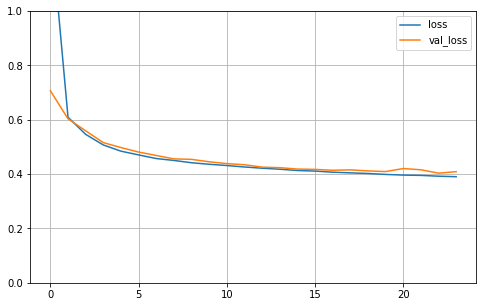

In [12]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [15]:
# reciprocal 是一个分布
from scipy.stats import reciprocal
# f(x) = 1/(x*log(b/a)) a <= x <= b

param_distribution = {
    "hidden_layers":[1, 2, 3, 4],
    "layer_size": np.arange(1, 100),
    # learning_rate 取连续的值，调用 reciprocal 函数
    "learning_rate": reciprocal(1e-4, 1e-2),
}

In [14]:
from scipy.stats import reciprocal
reciprocal.rvs(1e-4, 1e-2, size=10)

array([0.00026838, 0.00010295, 0.00066997, 0.00141476, 0.00110651,
       0.00032568, 0.005007  , 0.00375614, 0.00011667, 0.00019655])

In [19]:
from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model, param_distribution, n_iter=10, cv=3, n_jobs=1)

random_search_cv.fit(x_train_scaled, y_train, epochs=100, validation_data=(x_valid_scaled, y_valid), callbacks=callbacks)

# cross_validation: 训练集分成 n 份， n-1 份训练，最后 1 份验证，可以看到最后一次训练，遍历数据仍然变成了 11610 个

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 65us/sample - loss: 1.1937 - val_loss: 0.6820
Epoch 2/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.6470 - val_loss: 0.6452
Epoch 3/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.5828 - val_loss: 0.5537
Epoch 4/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.5425 - val_loss: 0.5293
Epoch 5/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.5098 - val_loss: 0.4936
Epoch 6/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.4879 - val_loss: 0.4817
Epoch 7/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.4730 - val_loss: 0.4591
Epoch 8/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.4590 - val_loss: 0.4488
Epoch 9/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.4501 - val_loss: 0.436

Epoch 4/100
7740/7740 [==============================] - 0s 41us/sample - loss: 1.7470 - val_loss: 1.5822
Epoch 5/100
7740/7740 [==============================] - 0s 43us/sample - loss: 1.3620 - val_loss: 1.2621
Epoch 6/100
7740/7740 [==============================] - 0s 45us/sample - loss: 1.1067 - val_loss: 1.0467
Epoch 7/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.9371 - val_loss: 0.9014
Epoch 8/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.8252 - val_loss: 0.8042
Epoch 9/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.7517 - val_loss: 0.7397
Epoch 10/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.7046 - val_loss: 0.6979
Epoch 11/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.6746 - val_loss: 0.6698
Epoch 12/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.6547 - val_loss: 0.6507
Epoch 13/100
7740/7740 [===================

Epoch 45/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.5069 - val_loss: 0.5223
Epoch 46/100
7740/7740 [==============================] - 0s 21us/sample - loss: 0.5045
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 66us/sample - loss: 6.2570 - val_loss: 5.1958
Epoch 2/100
7740/7740 [==============================] - 0s 38us/sample - loss: 4.0839 - val_loss: 3.6225
Epoch 3/100
7740/7740 [==============================] - 0s 38us/sample - loss: 2.9002 - val_loss: 2.6752
Epoch 4/100
7740/7740 [==============================] - 0s 39us/sample - loss: 2.1676 - val_loss: 2.0611
Epoch 5/100
7740/7740 [==============================] - 0s 41us/sample - loss: 1.6923 - val_loss: 1.6513
Epoch 6/100
7740/7740 [==============================] - 0s 53us/sample - loss: 1.3812 - val_loss: 1.3782
Epoch 7/100
7740/7740 [==============================] - 0s 49us/sample - loss: 1.1800 - val_loss: 1.1980
Epoch 8/100
774

Epoch 74/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.6050 - val_loss: 0.6467
Epoch 75/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.6032 - val_loss: 0.6448
Epoch 76/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.6014 - val_loss: 0.6429
Epoch 77/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.5996 - val_loss: 0.6411
Epoch 78/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.5979 - val_loss: 0.6392
Epoch 79/100
7740/7740 [==============================] - 0s 18us/sample - loss: 0.5952
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 64us/sample - loss: 2.2598 - val_loss: 1.2587
Epoch 2/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.9400 - val_loss: 0.8506
Epoch 3/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.7474 - val_loss: 0.7618
Epoch 4/100

7740/7740 [==============================] - 0s 37us/sample - loss: 0.4903 - val_loss: 0.5135
Epoch 24/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.4867 - val_loss: 0.5104
Epoch 25/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.4820 - val_loss: 0.5045
Epoch 26/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4791 - val_loss: 0.5010
Epoch 27/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.4754 - val_loss: 0.5013
Epoch 28/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4721 - val_loss: 0.4934
Epoch 29/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4687 - val_loss: 0.4882
Epoch 30/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.4668 - val_loss: 0.4841
Epoch 31/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.4640 - val_loss: 0.4843
Epoch 32/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 44us/sample - loss: 0.4064 - val_loss: 0.4037
Epoch 14/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.4019 - val_loss: 0.4090
Epoch 15/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.3991 - val_loss: 0.4041
Epoch 16/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.3959 - val_loss: 0.4019
Epoch 17/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.3905 - val_loss: 0.4064
Epoch 18/100
7740/7740 [==============================] - 0s 22us/sample - loss: 0.3869
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 66us/sample - loss: 1.1440 - val_loss: 0.6585
Epoch 2/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.5731 - val_loss: 0.5301
Epoch 3/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.4915 - val_loss: 0.4830
Epoch 4/100
7740/7740 [=

7740/7740 [==============================] - 0s 38us/sample - loss: 0.6271 - val_loss: 0.6442
Epoch 35/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.6238 - val_loss: 0.6405
Epoch 36/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.6207 - val_loss: 0.6369
Epoch 37/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.6175 - val_loss: 0.6335
Epoch 38/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.6145 - val_loss: 0.6304
Epoch 39/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.6114 - val_loss: 0.6267
Epoch 40/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.6085 - val_loss: 0.6237
Epoch 41/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.6056 - val_loss: 0.6205
Epoch 42/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.6027 - val_loss: 0.6172
Epoch 43/100
7740/7740 [==========================

Epoch 30/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.6378 - val_loss: 0.6668
Epoch 31/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.6322 - val_loss: 0.6613
Epoch 32/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.6268 - val_loss: 0.6559
Epoch 33/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.6216 - val_loss: 0.6509
Epoch 34/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.6167 - val_loss: 0.6459
Epoch 35/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.6119 - val_loss: 0.6412
Epoch 36/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.6073 - val_loss: 0.6367
Epoch 37/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.6027 - val_loss: 0.6319
Epoch 38/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.5983 - val_loss: 0.6275
Epoch 39/100
7740/7740 [=============

Epoch 29/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.7014 - val_loss: 0.7623
Epoch 30/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.6967 - val_loss: 0.7573
Epoch 31/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.6923 - val_loss: 0.7524
Epoch 32/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.6880 - val_loss: 0.7474
Epoch 33/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.6839 - val_loss: 0.7427
Epoch 34/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.6798 - val_loss: 0.7381
Epoch 35/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.6759 - val_loss: 0.7335
Epoch 36/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.6722 - val_loss: 0.7293
Epoch 37/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.6686 - val_loss: 0.7254
Epoch 38/100
7740/7740 [=============

7740/7740 [==============================] - 0s 19us/sample - loss: 1.3215
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 74us/sample - loss: 1.1086 - val_loss: 0.6791
Epoch 2/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.6243 - val_loss: 0.6336
Epoch 3/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.5800 - val_loss: 0.5723
Epoch 4/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.5388 - val_loss: 0.5260
Epoch 5/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.5007 - val_loss: 0.4944
Epoch 6/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4705 - val_loss: 0.4632
Epoch 7/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.4462 - val_loss: 0.4445
Epoch 8/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4309 - val_loss: 0.4324
Epoch 9/100
7740/7740 [======

7740/7740 [==============================] - 0s 39us/sample - loss: 0.4309 - val_loss: 0.4342
Epoch 24/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4289 - val_loss: 0.4305
Epoch 25/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4270 - val_loss: 0.4300
Epoch 26/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.4251 - val_loss: 0.4284
Epoch 27/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.4232 - val_loss: 0.4262
Epoch 28/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4216 - val_loss: 0.4229
Epoch 29/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.4183
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 72us/sample - loss: 2.0217 - val_loss: 0.7129
Epoch 2/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.5931 - val_loss: 0.6130
Epoch 3/100
7740/7740 [

7740/7740 [==============================] - 0s 42us/sample - loss: 0.5962 - val_loss: 0.6157
Epoch 39/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.5922 - val_loss: 0.6116
Epoch 40/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.5882 - val_loss: 0.6077
Epoch 41/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.5844 - val_loss: 0.6037
Epoch 42/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.5807 - val_loss: 0.5999
Epoch 43/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.5770 - val_loss: 0.5963
Epoch 44/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.5735 - val_loss: 0.5925
Epoch 45/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.5701 - val_loss: 0.5891
Epoch 46/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.5667 - val_loss: 0.5856
Epoch 47/100
7740/7740 [==========================

Epoch 38/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.6220 - val_loss: 0.6752
Epoch 39/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.6191 - val_loss: 0.6723
Epoch 40/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.6164 - val_loss: 0.6693
Epoch 41/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.6137 - val_loss: 0.6666
Epoch 42/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.6112 - val_loss: 0.6635
Epoch 43/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.6086 - val_loss: 0.6607
Epoch 44/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.6061 - val_loss: 0.6578
Epoch 45/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.6037 - val_loss: 0.6553
Epoch 46/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.6014 - val_loss: 0.6525
Epoch 47/100
7740/7740 [=============

Epoch 47/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.4997 - val_loss: 0.5404
Epoch 48/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4979 - val_loss: 0.5385
Epoch 49/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.4962 - val_loss: 0.5365
Epoch 50/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.4945 - val_loss: 0.5343
Epoch 51/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.4928 - val_loss: 0.5320
Epoch 52/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4911 - val_loss: 0.5302
Epoch 53/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4895 - val_loss: 0.5284
Epoch 54/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.4879 - val_loss: 0.5265
Epoch 55/100
7740/7740 [==============================] - 0s 20us/sample - loss: 0.4854
Train on 7740 samples, validate on 3870 samples
Epoch 1/

7740/7740 [==============================] - 0s 42us/sample - loss: 0.8998 - val_loss: 0.9474
Epoch 8/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.8425 - val_loss: 0.8914
Epoch 9/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.8014 - val_loss: 0.8506
Epoch 10/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.7701 - val_loss: 0.8190
Epoch 11/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.7460 - val_loss: 0.7947
Epoch 12/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.7271 - val_loss: 0.7743
Epoch 13/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.7119 - val_loss: 0.7582
Epoch 14/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.6993 - val_loss: 0.7442
Epoch 15/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.6887 - val_loss: 0.7327
Epoch 16/100
7740/7740 [============================

Epoch 10/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.6920 - val_loss: 0.7374
Epoch 11/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.6772 - val_loss: 0.7234
Epoch 12/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.6654 - val_loss: 0.7119
Epoch 13/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.6557 - val_loss: 0.7023
Epoch 14/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.6473 - val_loss: 0.6940
Epoch 15/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.6398 - val_loss: 0.6860
Epoch 16/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.6330 - val_loss: 0.6791
Epoch 17/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.6266 - val_loss: 0.6723
Epoch 18/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.6205 - val_loss: 0.6660
Epoch 19/100
7740/7740 [=============

Epoch 20/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.5834 - val_loss: 0.6439
Epoch 21/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.5786 - val_loss: 0.6389
Epoch 22/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.5740 - val_loss: 0.6333
Epoch 23/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.5695 - val_loss: 0.6284
Epoch 24/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.5652 - val_loss: 0.6234
Epoch 25/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.5609 - val_loss: 0.6185
Epoch 26/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.5569 - val_loss: 0.6141
Epoch 27/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.5529 - val_loss: 0.6098
Epoch 28/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.5490 - val_loss: 0.6050
Epoch 29/100
7740/7740 [=============

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x13fa345c0>,
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'hidden_layers': [1, 2, 3, 4], 'layer_size': array([ 1,  2, ..., 98, 99]), 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x142173cf8>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [21]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

{'hidden_layers': 4, 'layer_size': 58, 'learning_rate': 0.005740738090802875}
-0.34587740203258194


In [23]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

5160/5160 [==============================] - 0s 21us/sample - loss: 0.3982


0.398169884478399